In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import itertools
from itertools import cycle

%load_ext autoreload
%autoreload 2

import helpers.helper as helpers
import grading.save_student_results as save_student_results

mpl.rc('figure', max_open_warning = 0)

%matplotlib inline

### Note: Each cell can be evaluated for multiple input cases and the grading will be based on the number of correct outputs.

# Graded Exercise 1 

**Date: 05.11.2021**

Welcome to the first graded exercise. In this exercise, you will be tested on the topics of Linear Regression, SVM and KNN.

You are asked to fill in the code in a couple of cells throughout the exercise. In the end of each cell where we ask you to fill in some code, you will notice a call to a function from the `save_student_results` module. This ensures that the body of your function is run with pre-generated data and your current results are saved to a file (which you will eventually submit to Moodle). The cells are independent of each other and you will receive points for each individual cell. We will not grant partial points within a cell.

Before you finish, please make sure to **upload two files to Moodle**:
* **graded_exercise_1.ipynb**
* **answers_SCIPER.npz (e.g. "answers_280595.npz")**

Good luck! :)

### Important: Enter your SCIPER number below and run the cell

In [2]:
sciper_number = 342296  # e.g. 123456
save_student_results.initialize_res(locals())

## Part 1: Linear Regression


### 1.1 Introducing the data

Noticing the lack of bubble tea on campus, you have decided to open a bubble tea cafe. You will be offering 5 different flavours of tea: black tea, earl gray, jasmine, oolong and hibiscus. Since you want to offer the best possible experience, you will be freshly brewing the tea each morning.

Of course, since you are also a machine learning enthusiast, you'd like to have the help of machine learning to know exactly what amounts of tea you should brew for the upcoming day, so that you don't run out and you don't waste tea. Luckily, you have access to a dataset, which documents the amount of tea flavor sold each day. 

We have our data $\mathbf{X}$ of shape $N \times D$, where $N=5000, D=12$  with the following features:
- the temperature of the day
- the total number of students who have had lunch in the cafeterias
- the total number of food trucks on campus
- whether it is a vegetarian food day
- whether there is a student event on campus or not
- total number of times the coffee machines were used on campus
- what day of the week it is (spans across 5 features, in one-hot format, e.g., Wednesday corresponds to [0 0 1 0 0] )
- bias term

Our labels $\mathbf{Y}$ are of shape $N \times C$, where $N=5000, C=5$, where each column of $\mathbf{Y}$ corresponds to the amount of bubble tea sold for each flavor: black tea, earl gray, jasmine, oolong and hibiscus. Let us load this data.

In [3]:
X = np.load("./datasets/linear_reg/bubbletea_data.npy")
Y = np.load("./datasets/linear_reg/bubbletea_labels.npy")
print(X.shape, Y.shape)

(5000, 12) (5000, 5)


We soon receive the news that the dataset contains a mistake: one of the features carries no useful information because it is set to all zeros. Use the following function to detect which feature is problematic (return the index of the feature) and remove the feature from the data. 

In [4]:
mine = np.random.randint(1,10,(10,5))
mine[:,np.random.randint(0,5)] = 0
mine

array([[9, 2, 0, 6, 1],
       [3, 9, 0, 4, 8],
       [8, 6, 0, 6, 1],
       [6, 2, 0, 4, 9],
       [7, 4, 0, 1, 1],
       [2, 8, 0, 6, 9],
       [9, 1, 0, 4, 3],
       [1, 3, 0, 3, 2],
       [1, 4, 0, 7, 3],
       [8, 9, 0, 8, 8]])

In [5]:
print(np.abs(mine))
print(np.sum(np.abs(mine),axis = 0))
midx = np.argsort(np.sum(np.abs(mine),axis = 0))[0]
print(midx)

[[9 2 0 6 1]
 [3 9 0 4 8]
 [8 6 0 6 1]
 [6 2 0 4 9]
 [7 4 0 1 1]
 [2 8 0 6 9]
 [9 1 0 4 3]
 [1 3 0 3 2]
 [1 4 0 7 3]
 [8 9 0 8 8]]
[54 48  0 49 45]
2


In [6]:
np.concatenate((mine[:,:midx],mine[:,midx+1:]),axis = 1)

array([[9, 2, 6, 1],
       [3, 9, 4, 8],
       [8, 6, 6, 1],
       [6, 2, 4, 9],
       [7, 4, 1, 1],
       [2, 8, 6, 9],
       [9, 1, 4, 3],
       [1, 3, 3, 2],
       [1, 4, 7, 3],
       [8, 9, 8, 8]])

In [7]:
def remove_faulty_feature(X):
    """
        Function definition: 
            Find the faulty feature and return the index. Also return the data with the faulty feature removed
        
        args:
            X (np.array): Data array of shape NXD
        returns:
            faulty_feature_ind (int): Index of the faulty feature (feature indices start from 0)
            X (np.array): Data array of shape NX(D-1)
    """
    faulty_feature_ind = np.argsort(np.sum(np.abs(X),axis = 0))[0]
    X = np.concatenate((
        X[:,:faulty_feature_ind],
        X[:,faulty_feature_ind+1:]
    ),axis = 1)
    return faulty_feature_ind, X

save_student_results.save_remove_faulty_feature(locals())

/home/ayhon/.config/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [8]:
faulty_feature_ind, new_X = remove_faulty_feature(X)

Note that from now on $D=11$.

Now let's split the data into training and test sets (this part has been provided for you.)

In [9]:
split_ratio = 0.8

N = new_X.shape[0]
indices = np.arange(N)

np.random.seed(42)
np.random.shuffle(indices)

X_train    = new_X[indices[0:int(N*split_ratio)],:] 
Y_train    = Y[indices[0:int(N*split_ratio)], :] 
X_test     = new_X[indices[int(N*(split_ratio)):],:] 
Y_test     = Y[indices[int(N*(split_ratio)):], :] 

### 1.2 Closed-form solution:

Let us implement the linear regression model. We will be using the closed-form (analytical) solution seen in class. Reminder: you can use the function `np.linalg.pinv` for the pseudo-inverse! Fill in the function `get_w_analytical` to return the weights of the linear regression model.

In [10]:
def get_w_analytical(X,Y):
    """
        Function definition:
            Find the weights of the linear regression model according to the closed-form solution.
        args:
            X (np.array): Data array of shape NXD
            Y (np.array): Labels array of shape NXC
        returns:
            weights (np.array): Model parameters of shape DXC
    """
    ### YOUR CODE HERE
    w = np.linalg.inv(X.T @ X) @ X.T @ Y
    return w


save_student_results.save_get_w_analytical(locals())

In [11]:
weights = get_w_analytical(X_train, Y_train)
print("Weights have shape", weights.shape)

Weights have shape (11, 5)


### 1.3 Evaluating the model

Let's define the RMSE of multiple outputs as

$$
\text{RMSE} = \sqrt{\frac{1}{C}\sum_{c=1}^C \frac{1}{N}\sum_{n=1}^N (\mathbf{Y}_{n,c} -  \hat{\mathbf{Y}}_{n,c})^2}
$$

where $\hat{\mathbf{Y}}$ are our predictions using the model we just optimized.

Compute the RMSE value of the test data. Fill in the function below:

> Since
 $$
 \sqrt{\frac{1}{C}\sum^C_{c = 1}\frac{1}{N}\sum^N_{n=1}(Y_{n,c} - \hat{Y}_{n,c})^2} = 
 \sqrt{\frac{1}{C}\frac{1}{N}\sum^C_{c = 1}\sum^N_{n=1}(Y_{n,c} - \hat{Y}_{n,c})^2}
 $$
> we can worry about the $\frac{1}{N\cdot D}$ at the end of the operation and compute 
 $$
 \sqrt{\sum^C_{c = 1}\sum^N_{n=1}(Y_{n,c} - \hat{Y}_{n,c})^2}
 $$
> first

In [12]:
m1 = np.random.randint(1,20,(5,5))
m2 = np.random.randint(1,20,(5,5))

In [13]:
np.sum((m1 - m2)**2,axis = None)

1676

> **Note:** Look at return types, perhaps that solves the error

In [14]:
def RMSE(X, Y, weights):
    """
        Function definition:
        
        args:
            X (np.array): Data array of shape NXD
            Y (np.array): Labels array of shape NXC
            weights (np.array): Model parameters of shape DXC
        returns:
            rmse (float): RMSE value 
    """
    Y_hat = X @ weights
    N = Y.shape[0]
    C = Y.shape[1]
    
    diff = (Y - Y_hat)
    sum_of_squares = np.sum(diff**2,axis = None)
    square_root_of_sum = np.sqrt(sum_of_squares)
    
    rmse = square_root_of_sum/(N*C)
    return rmse

save_student_results.save_RMSE(locals())

In [15]:
rmse = RMSE(X_test, Y_test, weights)
print("RMSE is", rmse)

RMSE is 10.439996087676699


### 1.4 Analyzing the weights

Now we will be analyzing the weights we just optimized. We would like to find which features of the data correlate positively with the different flavors of tea. For instance, we would like to know which features of the data cause higher sales of "oolong" bubble tea. Fill in the function below which returns the indices of the features that are positively correlated with higher sales of a specified flavor. 

Note: we are not interested in the index of the bias feature!

In [16]:
np.argwhere(m1[2] - 10 > 0).flatten()

array([2, 3])

In [17]:
def positively_correlated_features(weights, flavor):
    """
        Function definition:
            This function helps us analyze the relationship between the data features and the weights. 
        args:
            weights (np.array): Weights matrix of shape DxC
            flavor (str): One of either "blacktea", "earlgray", "jasmine", "oolong", "hibiscus"
        returns:
            pos_corr_feat_ind (list or np.array): list of indices of features which have a
                                                    positive correlation (feature indices start with 0)
    """
    keys = ["blacktea", "earlgray", "jasmine", "oolong", "hibiscus"]
    ### YOUR CODE HERE:
    cat_ind = keys.index(flavor)
    
    # Now we know that weights[:,cat_ind]
    corr_feat_for_cat = weights[:,cat_ind]
    pos_corr_feat_ind = np.argwhere(corr_feat_for_cat > 0).flatten()
    
    ###
    return pos_corr_feat_ind

save_student_results.save_positively_correlated_features(locals())

In [18]:
pos_corr_feat_ind = positively_correlated_features(weights, "hibiscus")
print("Positively correlated indices are", pos_corr_feat_ind)

Positively correlated indices are [1 3 4 5 7 9]


## Part 2. SVM

### 2.1 Equal distances to the decision boundary
As it was discussed during the lectures, different classifiers have different decision boundaries. SVM is designed to find a decision boundary which is as far as possible from the training points of both classes. 
In this exercise, we propose to verify that this property holds for a trained SVM. Note that we restrict ourselves to the **linearly-separable** scenario. 

> This means that we don't need to consider slack variables $\xi_i$

Let's denote the "minimal distance" to the decision boundary for class $i$ in the case of **linearly-separable** classes as
$$ d_i = \min_{j \in C_i}{ r_j }$$
where $r_j$ is the distance between the sample $x_j$ of class $i$ and the decision boundary, and $C_i$ is the set of the indices of the samples belonging to class $i$.

The task of this exercise is to check that these minimal distances for both classes are indeed equal.

We provide the data and the model that we used in class. You can use them for debugging your code.

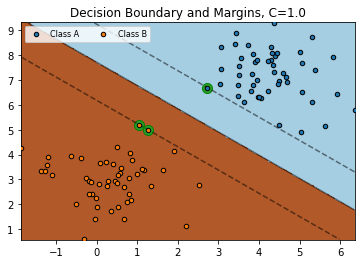

In [19]:
from sklearn.svm import SVC


# Get the simple dataset
X, Y = helpers.get_simple_dataset()
 
# Create an SVM model with a linear kernel and C=1.0
clf = SVC(kernel='linear', C=1.)

# Train the model
clf.fit(X, Y)

# Plot its decision boundary
helpers.plot(X, Y, clf)

# Get the primal coefficients of this trained SVM model
w = clf.coef_[0]
w0 = clf.intercept_

### 2.2 Distance to the decision boundary

As a reminder, the absolute (i.e., unsigned) distance to the decision boundary for a data sample $x$ is given by
$$r = \frac{|\hat{y}(\mathbf{x})|}{\|\tilde{\mathbf{w}}\|} = \frac{|\tilde{\mathbf{w}}^T\mathbf{x} + w^{(0)}|}{\|\tilde{\mathbf{w}}\|}$$
(Note that, for linearly separable data, using the absolute value $|\hat{y}(\mathbf{x})|$ is equivalent to multiplying the prediction $\hat{y}(\mathbf{x})$ by the true label $y$ as seen in class.) 

Your first task is therefore to implement the computation of $\hat{y}(\mathbf{x}) = \tilde{\mathbf{w}}^T\mathbf{x} + w^{(0)}$ in `decision_function`. Complete the following code:

In [20]:
# Use the weights (w and w0) from the fitted model to predict the decision function value of input data points
# Beware: the expected output is an array of floating point values (y_hat), not the predicted class.

def decision_function(x, w, w0):
    '''
    given input data, w and w0, output the VALUE of the decision function (y^hat) for data points x
    
    input:
    x: data, np.array of shape (N, D) where N is the number of datapoints and D is the dimension of features.
    w: weights, np.array of shape (D,)
    w0: bias, np.array of shape (1,)
    
    output:
    y_hat: decision function values, np.array of shape (N, ). 
    '''
    ## CODE HERE
    return x @ w + w0

save_student_results.decision_function(locals())

y_hat = decision_function(X, w, w0)

/home/ayhon/.config/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Now use the above `y_hat` to compute the unsigned distance of the N data points to the decision boundary.

*Hint: to compute the norm of a vector you can use* `np.linalg.norm()`

In [21]:
def dist(y_hat, w):
    """
    Computes the minimum distance between the decision boundary and the samples of the class.
    
    Parameters: 
        y_hat: np.array of shape (N, ) where N is the number of data samples: values of the decision function for these data samples
        w (np.array, shape (D,) ): Primal weights
    Returns:
        d (N, ): distances of the N data samples to the decision boundary
    """ 
    ### CODE HERE
    d = np.abs(y_hat)/np.linalg.norm(w)
    
    return d

save_student_results.dist(locals())

r = dist(y_hat, w)

### 2.3 Equality of the SVM margins

We have implemented above the computation of distances between all data points and the decision boundary. These distances are stored in `r`. We now need to split these distances into 2 arrays: `r_pos` containing the distances of points with ground-truth label +1, and `r_neg` containing distances of points with ground-truth label -1.

In [22]:
def split_dists(r, Y):
    """
    Splits array r based on ground truth labels Y
    
    Parameters: 
        r (np.array, shape (N,) ): unsigned distance of N data samples to the decision boundary
        Y (np.array, shape (N,)): Ground-truth labels (1 or -1) corresponding to every sample in X
    Returns: with N=M+L
        r_pos (np.array, shape (M,) ): distances to the decision boundary of data samples with label +1
        r_neg (np.array, shape (L,) ): distances to the decision boundary of data samples with label -1
    """
    ### CODE HERE
    r_pos = r[Y > 0]
    r_neg = r[Y < 0]
    # There should be  no instace of Y == 0, as the datasets are separable

    return r_pos, r_neg

save_student_results.split_dists(locals())

r_pos, r_neg = split_dists(r, Y)

Let's now check that the minimum distances to the decision boundary for both classes are equal. Since the trained SVM model is the result of a numerical process, small errors can accumulate. We will therefore not actually check for a strict equality but for closeness: we define scalars $a$ and $b$ as being close when
$$| a - b | < 10^{-4}$$

In [23]:
def are_minimum_distances_close(r_pos, r_neg):
    """
    Returns True iff the minimum of r_pos and r_neg are close to each other (up to 1e-4)
    
    Parameters: 
        r_pos (np.array, shape (M,) ): distances to the decision boundary of data samples with label +1
        r_neg (np.array, shape (L,) ): distances to the decision boundary of data samples with label -1
    Returns:
        (bool): True iff the minimum of r_pos and r_neg are close to each other (up to 1e-4)
    """ 
    def areClose(a,b):
        return np.abs(a-b) < 1e-4
    
    return areClose(
        np.min(r_pos),
        np.min(r_neg)
    )

save_student_results.are_minimum_distances_close(locals())

eq_min_distances = are_minimum_distances_close(r_pos, r_neg)
print(f'Distances are equal: {eq_min_distances}')

Distances are equal: True


### 2.4 Analyzing slack variables 

Assume that the SVM model was trained on **non linearly-separable** data this time. Here is the classic (primal) formulation of SVM that was used:

$$
\begin{align}
        \underset{\tilde{\mathbf{w}},w^{(0)},{\{\xi_i\}}}{\operatorname{min}}  \ \ & \frac{1}{2}\|\tilde{\mathbf{w}}\|^2 + C \sum^N_{i=1}\xi_i \\
        \operatorname{subject \  to} \ \ &  y_i(\tilde{\mathbf{w}}^T\mathbf{x_i}+w^{(0)}) \geq 1-\xi_i , \forall \  i \\
                          &  \xi_i \geq 0 , \forall \  i
    \end{align}
$$

where $\tilde{\mathbf{w}}$,$w^{(0(}$ are the weights and the bias, $C$ weighs the penalty term, $\xi_i$ is a slack variable encoding how far data point $i$ is beyond the correct margin and $y_i \in\{-1,1\}$ is the ground-truth label of sample $i$.

Suppose that the person who trained the SVM did not properly save the trained weights, but instead saved the values of the slack variables only. As a result, the array of slack variables $\{\xi_i\}$ that correspond to the training samples $\{x_i\}$ is the **only** data that is available to you.

Number of slack variables:  500


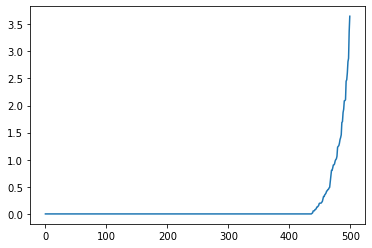

In [24]:
# Load slack variables
slacks = np.load('./datasets/svm/slack_array.npy')
plt.plot(sorted(slacks))
print('Number of slack variables: ', slacks.shape[0])

#### 2.4.1 Task:
Given the array of slack variables, we would like to recover some information about the lost SVM model. You are asked to compute the following statistics based on the slack variables' values:
* Accuracy of classification for the training samples $\Big(\frac{\text{# correct predictions}}{\text{# samples}}\Big)$ . We consider a point to be correctly classified if it lies **strictly** on the correct size of the decision boundary (and not on it).
* Number of training points that simultaneously respect all the following conditions:
  1. lie **strictly between the margins**
  2. are correctly classified
  3. are not on the decision boundary

In [25]:
def accuracy(slacks):
    '''
    Returns the accuracy.
    Parameters: 
        slacks (np.array, shape (N,) ): Slack variables
    Returns:
        accuracy (float): the ratio of correctly classified samples
    '''
    ### CODE HERE
    # The number of samples is already known (N)
    num_samples = len(slacks)
    
    # We now need to find the correct predictions. 
    # We know that if a point was correctly classified, then
    # y(wx + w0) must be greater than 0 (Since both y and yhat)
    # must have the same sign. If y(wx + w0) isn't positive, it
    # implies that the \xi_i must be greater than 1 (If not, it
    # wouldn't hold that y(wx + w0) >= 1 - \xi_i). We can therefore
    # use this to detect the correct predictions
    num_correct_predictions = np.sum(np.where(slacks <= 1, 1, 0))
    
    return num_correct_predictions / num_samples

print(f'Accuracy: {accuracy(slacks)*100:.2f}%')

save_student_results.accuracy(locals())


Accuracy: 95.20%


In [26]:
def in_correct_margin(slacks):
    '''
    Returns the number of samples that are classified correctly but strictly between the margins
    Parameters: 
        slacks (np.array, shape (N,) ): Slack variables
    Returns:
        num_in_margin (int)
    '''
    ### CODE HERE
    return np.sum(np.where(np.bitwise_and(0 < slacks, slacks <= 1), 1, 0))

save_student_results.in_correct_margin(locals())

print(f'Number of samples inside the margin: {in_correct_margin(slacks)} out of {slacks.shape[0]}')

Number of samples inside the margin: 40 out of 500


## Part 3. Weighted k-NN Classifier with Feature Expansion

### 3.1 Data loading

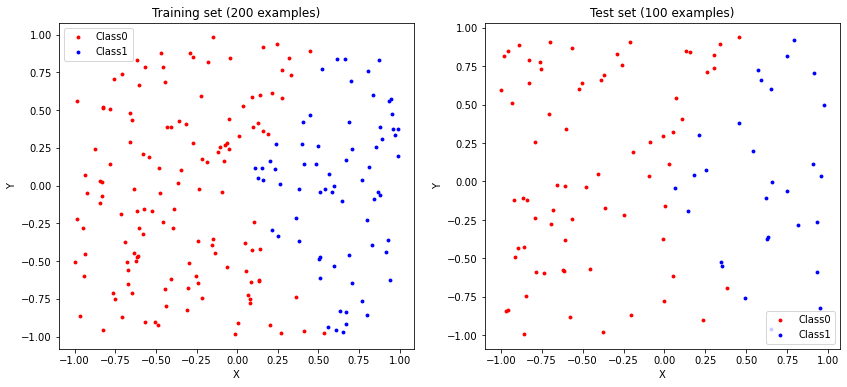

In [27]:
data_train, data_test, labels_train, labels_test, class_names = helpers.load_knn_data()
colors = np.array([[1.0, 0.0, 0], [0, 0, 1.0]])
helpers.plot_knn_training_test(data_train, data_test, labels_train, labels_test, colors, class_names)

No. of examples in training set : 200
No. of examples in test set     : 100
No. of features in the data     : 2
No. of classes present          : 2


Text(0.5, 1.0, 'Histogram plot of each class in the training set')

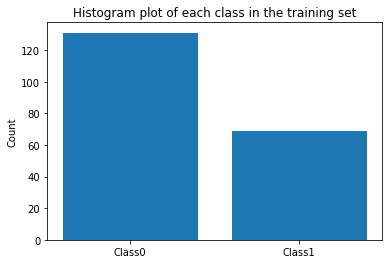

In [28]:
print("No. of examples in training set : {}".format(data_train.shape[0]))
print("No. of examples in test set     : {}".format(data_test.shape[0]))
print("No. of features in the data     : {}".format(data_train.shape[1]))
print("No. of classes present          : {}".format(len(np.unique(labels_train))))


plt.bar(class_names, np.bincount(labels_train))
plt.ylabel('Count')
plt.title('Histogram plot of each class in the training set')

### 3.2 Distance metrics

In this exercise, we first ask you to implement both the Manhattan distance (a.k.a. L1 distance) and the cosine similarity distance. 

**Manhattan distance:** The Manhattan distance between two vectors $\mathbf{v}\in\mathbf{R}^D$ and $\mathbf{w}\in\mathbf{R}^D$ is given by

$$
\text{Manhattan}(\mathbf{v}, \mathbf{w}) = { \sum_{i=1}^{D} |\mathbf{v}^{(i)} - \mathbf{w}^{(i)}| }
$$

where $\mathbf{v}^{(i)}$ denotes the value in the dimension $i$ of $\mathbf{v}$.

**Cosine similarity:** The cosine similarity is a measure of similarity between two non-zero vectors. From elementary geometry, recall that the cosine of the angle between two vectors is given by

$$
\text{cosine}(\mathbf{v}, \mathbf{w}) = \frac{ \sum_{i=1}^{D}  \mathbf{v}^{(i)} . \mathbf{w}^{(i)} }{\| \mathbf{v} \| \| \mathbf{w} \| }
$$

Then we can define a cosine distance metric as

$$
d(\mathbf{v}, \mathbf{w}) = 1 - \text{cosine}(\mathbf{v}, \mathbf{w})
$$





#### Implement manhattan distance below

In [29]:
m5 = np.random.randint(0,20,20)
m3 = np.random.randint(0,20,(5,20))
print(m5.shape)
print(m3.shape)

(20,)
(5, 20)


In [30]:
np.abs(m3 - m5).shape

(5, 20)

In [31]:
def manhattan_distance(test_example, training_examples):
    """
    Computes the Manhattan distance between a single test_example 
    and the complete training data
    
    Parameters: 
        test_example (np.array): Data sample of shape (D,)
        training_examples (np.array): Matrix of training data samples of shape (N,D)
    Returns:
        distances:  (np.array) of shape (N,)
    """ 
    
    #------------------ WRITE YOUR CODE HERE --------------------------
    distances = np.sum(np.abs(training_examples - test_example), axis=1, keepdims=True)
    
    return distances

save_student_results.save_manhattan_distance(locals())

#### Implement cosine distance below

In [32]:
np.sum(m5 * m3, axis = 1)

array([1338, 1797, 2057, 2238, 1538])

In [33]:
norm = np.linalg.norm
norm(m3, axis = 1)

array([42.94182111, 52.12485012, 56.77147171, 58.96609195, 49.10193479])

In [34]:
def cosine_distance(test_example, training_examples):
    """
    Computes the cosine distance between a single test example 
    and the complete training data
    
    Parameters: 
        test_example (np.array): Data sample of shape (D,)
        training_examples (np.array): Matrix of training data samples of shape (N,D)
    Returns:
        distances :  (np.array) of shape (N,)
    """ 
    
    #------------------ WRITE YOUR CODE HERE --------------------------

    norm = np.linalg.norm
    v = test_example
    w = training_examples
    return (np.sum(v * w, axis=1, keepdims=True)/(norm(v) * norm(w, axis=1))).flatten()

save_student_results.save_cosine_distance(locals())

> Consine distance
$$
\text{cosine}(\mathbf{v}, \mathbf{w}) = \frac{ \sum_{i=1}^{D}  \mathbf{v}^{(i)} . \mathbf{w}^{(i)} }{\| \mathbf{v} \| \| \mathbf{w} \| }
$$
>


### 3.2 Weighed k-NN


During the previous exercise session, we considered a setting in which the label of the test sample was predicted as the most frequent label in the list of nearest neighbors' labels.  

Here, we ask you to implement a more sophisticated prediction scheme, where the k-nearest neighbors' labels $y_i \in \{0, 1\}$ for $i \in \{1,..k\}$  are weighted by the inverse of the distance $d(\mathbf{u},\mathbf{v_i})$ between the training sample  $\mathbf{v}_i$ and the test sample $\mathbf{u}$ , i.e.,

$$
y = \text{round}\left( \frac{ \sum_{i=1}^k \frac{1}{d(\mathbf{u},\mathbf{v}_i)} y_i } { \sum_{i=1}^k \frac{1}{d(\mathbf{u},\mathbf{v}_i)}} \right)
$$


#### Implement this weighting scheme below.

In [35]:
def predict_label(neighbor_labels, neighbor_distances):
    
    """predict the label by weighing the nearest neighbors' label with the inverse
    distance to the sample.
    
    Input:
        neighbor_labels (np.array, int datatype): shape (k,)
        neighbor_distances(np.array): shape (k,)
        
    Output:
        output_label (integer)
    """

    #------------------ WRITE YOUR CODE HERE --------------------------
    
    denominator = np.sum(neighbor_labels / neighbor_distances)
    numerator = np.sum(1/neighbor_distances)
    
    weighted_labels = denominator / numerator
    
    ## np.around() returns a floating value.  (e.g. 1.0 )
    ## we change it to integer to return the assigned label  (e.g. 1)
    return int(np.around(weighted_labels))

save_student_results.save_predict_label(locals())

### 3.3 Feature expansion


In this section, we ask you to expand the original input features. 

Given the input data $\mathbf{X}\in\mathbf{R}^{N \times D}$, let $\mathbf{X}^{(i)}\in \mathbf{R}^{N \times 1}$ denote the values of feature $i$ for all samples, corresponding to column $i$. We expand the original features by 

1. computing all pairwise features $\mathbf{X}^{(i)}  . \mathbf{X}^{(j)}$ by multiplying any two features $\mathbf{X}^{(i)}$ and $\mathbf{X}^{(j)}$ for $j \in {\{0,...,i-1\}}$,  $i \in {\{1,...,D-1\}}$. 
  This yields $F_1= \frac{D\cdot(D-1)}{2}$ additional terms. 
 
<p></p>


2. computing all terms of higher degree up to $M$ for each feature $\mathbf{X}^{(i)}$. We compute the $m^{th}$ power of each feature $\mathbf{X}^{(i)}$ for $m$ ranging from 2 to $M$. Because of this expansion, we get  $F_2= (M-1)\cdot D$ additional features.
<p></p>


In the end, we obtain final features of dimension $F$ = $D$ + $F_1$ + $F_2$.




###### Implement the feature expansion function below.

In [47]:
"""
Hints,
#  You may use np.concatenate((input1, input2), axis=..) to combine the the features. 
#  Before concatenating, make sure the number of dimensions in both inputs are same 
#  Both the inputs must have the same shape, except in the dimension along which concatenation is done 

Input: X = [[ 1  2]
            [ 3  4]]
        (np.array) shape (2, 2)

        M = 5

Output = [[   1    2    2    1    4    1    8    1   16    1   32]
          [   3    4   12    9   16   27   64   81  256  243 1024]]
          
          (np.array) shape (2,11)
          
The first D=2 columns are the original features. The third column contains the F1 = 1 pairwise term.
The rest of the  F2 = 8  columns belongs to higher degree terms for m = 2, 3, 4 and 5.

"""


def feature_expansion(X, M):
    """
    Expands the given features with pairwise products and higher degree features
    Parameters: 
        X (np.array): Data samples of shape (N,D)
        M (integer):  expansion degree M
    Returns:
        expanded_X (np.array): Expanded data samples of shape (N,F), 
        where F is the total number of features after expansion as above
        
    """ 
    #------------------------------- WRITE YOUR CODE HERE --------------------------
    D = X.shape[1]
    
    pairwise = []
    for i in range(D):
        for j in range(i+1,D): # We dont what i == j, thats X**2
            pairwise.append(X[:,i] * X[:,j])
    pairwise = np.array(pairwise) # D·(D+1)/2 x N
    
    higher_degree = []
    for i in range(D):
        for m in range(2,M+1): # We want to include M
            higher_degree.append(X[:,i]**m)
    higher_degree = np.array(higher_degree) # D·(M-1) x N
    
    
    expanded_X = np.concatenate(
        (
            X,
            np.array(pairwise).T,
            np.array(higher_degree).T
        ),
        axis = 1
    )
    
    # ------------------------------------------------------------------------------
        
    return expanded_X

save_student_results.save_feature_expansion(locals())

/home/ayhon/.config/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [51]:
newX = np.random.random((N,D))
print(newX.shape)
feature_expansion(newX,10).shape


NameError: name 'D' is not defined

> 1. computing all pairwise features $\mathbf{X}^{(i)}  . \mathbf{X}^{(j)}$ by multiplying any two features $\mathbf{X}^{(i)}$ and $\mathbf{X}^{(j)}$ for $j \in {\{0,...,i-1\}}$,  $i \in {\{1,...,D-1\}}$. 
  This yields $F_1= \frac{D\cdot(D-1)}{2}$ additional terms. 
> 
> 2. computing all terms of higher degree up to $M$ for each feature $\mathbf{X}^{(i)}$. We compute the $m^{th}$ power of each feature $\mathbf{X}^{(i)}$ for $m$ ranging from 2 to $M$. Because of this expansion, we get  $F_2= (M-1)\cdot D$ additional features.


#### Below, we provide a helper function to find the indices of the k smallest distances

In [37]:
# Find the indices of the k shortest distances from a array of distances
def find_k_nearest_neighbors(k, distances):
    """ find indices of the k smallest distances
    Inputs:
        k (integer)
        distances (np.array): shape (N,)
    Outputs:
        indices (np.array): shape (k,)
    """
    indices = np.argsort(distances)[:k]
    return indices        

### 3.4 Putting everything together (Just run all the cells below)
Now we combine the functions we have written above to predict the label of one test example. We further provide a function **kNN** that applies **kNN_one_example** to an arbitrary number of examples (as you had in the exercise session). 

In [38]:
def kNN_one_example(unlabeled_example, training_features, training_labels, k, distance):
    """ run kNN algorithm on one example
    Inputs:
        unlabeled_example (np.array): shape (D,)
        training_features(np.array): shape (N,D)
        training_labels(np.array): shape (N)
        k (integer)
        distance (string): which distance to compute
    Outputs:
        label (integer)
    """
    
    if distance == "manhattan":
        distances = manhattan_distance(unlabeled_example, training_features)
    elif distance == "cosine":
        distances = cosine_distance(unlabeled_example, training_features)
    
    nn_indices = find_k_nearest_neighbors(k, distances) 
    neighbor_labels = training_labels[nn_indices]
    neighbor_distances = distances[nn_indices]
    best_label = predict_label(neighbor_labels, neighbor_distances) 
    return best_label

def kNN(unlabeled, training_features, training_labels, k, distance):
    return np.apply_along_axis(kNN_one_example, 1, unlabeled, training_features, training_labels, k, distance)

Let us also provide the following feature normalization function.

In [39]:
def normalize(x, means, stds):
    """ normalize the data using means and stds
    Inputs:
        x (np.array): Input data of shape (N,D)
        means (np.array): shape (1,D)
        stds (np.array): shape (1,D)
        
    Outputs:
        normed_data: shape (N,D)
    """
    
    return (x-means)/stds

You can now run the cell below to see your model's results using both metrics.

In [40]:
# highest degree of expansion
M = 5

data_train_expanded =  feature_expansion(data_train, M)
data_test_expanded  =  feature_expansion(data_test, M)

mean_val = data_train_expanded.mean(axis=0, keepdims=True)
std_val  = data_train_expanded.std(axis=0, keepdims=True)
norm_train_data_expanded = normalize(data_train_expanded, mean_val, std_val)
norm_test_data_expanded  = normalize(data_test_expanded, mean_val, std_val)

print("No of features in the original data: {}".format(data_train.shape[1]))
print("No of features in the expanded data: {}\n".format(data_train_expanded.shape[1]))

# No. of nearest neighbors
k = 5

# run weighted-KNN classifier with both distance metrics
for distance_type in ["manhattan",  "cosine"]:
    predicted_labels_test = kNN(norm_test_data_expanded, norm_train_data_expanded, 
                                labels_train, k, distance_type)
    
    accuracy = helpers.my_accuracy_func(predicted_labels_test, labels_test)
    print("Distance type: {:12s} Test Accuracy: {:.2f}%".format(distance_type, 100*accuracy))

No of features in the original data: 2
No of features in the expanded data: 11

Distance type: manhattan    Test Accuracy: 0.00%


IndexError: index 8366 is out of bounds for axis 0 with size 200